# Helsinki City Bikes: Network Analysis
# Suhas K & Shreya Mandi
## Importing libraries and analysing the graph

In [1]:
import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
# GREEN = "#239B56"
# BLUE = "#5DADE2"

In [2]:
# For Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/helsinki-city-bikes/database.csv


In [3]:
dataframe = pd.read_csv("/kaggle/input/helsinki-city-bikes/database.csv")
dataframe.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,departure,return,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC)
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9


In [4]:
dataframe[['departure','return']] =  dataframe[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

## Creating the Graph object

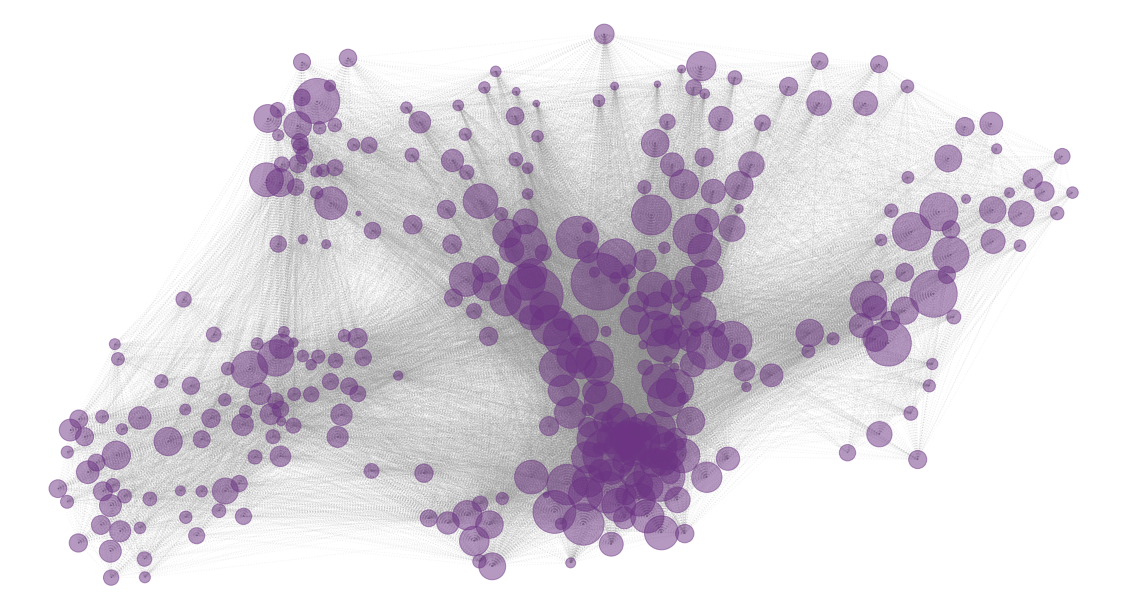

In [5]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=MAGENTA, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')

    return G

G = bikeNetwork(dataframe)

In [6]:
(df['departure_name'].value_counts()/15).tolist()

NameError: name 'df' is not defined

## Network Infomation

In [ ]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print(nx.info(G))

networkStats(G)

# Eigenvector Centrality

In [ ]:
from numpy import linalg as LA

## Using linalg numpy library to find eigenvalue

In [ ]:
def max_eigen_centrality(graph, n):

    eigen_values, eigen_vectors = LA.eig(graph)
#    print(eigen_values)

    max_eigen_value = max(eigen_values)
#     print(max_eigen_value)
    index = np.where(eigen_values == max_eigen_value)[0][0]

    eigen_vector = eigen_vectors[index]
    node_value = max(eigen_vector)
    node_index = np.where(eigen_vector == node_value)[0][0]

    return node_index, node_value, eigen_vector

In [ ]:
array=nx.to_numpy_array(G)
array

# Using QR algorithm to find maximum Eigen value within 20 iterations

In [ ]:
node_index, node_value, eigen_vector=max_eigen_centrality(array,nx.number_of_nodes(G))
print(node_index, node_value, eigen_vector)

# Using the max_eigen_val to find the basis of required eigen vector

In [ ]:
import numpy as np


def QR_Decomposition(A):
    n, m = A.shape

    Q = np.empty((n, n))
    U = np.empty((n, n))

    U[:, 0] = A[:, 0]
    Q[:, 0] = U[:, 0] / np.linalg.norm(U[:, 0])

    for i in range(1, n):

        U[:, i] = A[:, i]
        for j in range(i):
            U[:, i] -= (A[:, i] @ Q[:, j]) * Q[:, j]

        Q[:, i] = U[:, i] / np.linalg.norm(U[:, i])

    R = np.zeros((n, m))
    for i in range(n):
        for j in range(i, m):
            R[i, j] = A[:, j] @ Q[:, i]

    return Q, R


def max_eigen_val(A, level=1e-12, max_iter=20):
    A_old = np.copy(A)
    A_new = np.copy(A)

    diff = np.inf
    i = 0
    while (diff > level) and (i < max_iter):
        A_old[:, :] = A_new
        Q, R = QR_Decomposition(A_old)

        A_new[:, :] = R @ Q
        diff = np.abs(A_new - A_old).max()
        i += 1

    eigen_values = np.diag(A_new)

    return max(eigen_values)


def solve_eigen_vector(graph, eigen_val):

    eigen_values, eigen_vectors = np.linalg.eig(graph)

    eigen_val = np.max(eigen_values)
    index = np.where(eigen_values == eigen_val)[0][0]

    return eigen_vectors[index]


def max_eigen_centrality(graph, n):
    max_eigen_value = max_eigen_val(graph)

    eigen_vector = solve_eigen_vector(graph, max_eigen_value)

    node_value = np.max(eigen_vector)
    node_index = np.where(eigen_vector == node_value)[0][0]

    return node_index, node_value, eigen_vector


In [ ]:
res=max_eigen_centrality(array,nx.number_of_nodes(G))

In [ ]:
print(res)

In [ ]:
res[2]

# Accuracy lower when max_iter=10

In [ ]:
#max_iter 10
print(eigen_values)
# print(max(eigen_values))

# Accuracy greater when max_iter=100

In [ ]:
#max_iter 100
print(eigen_values)
# print(max(eigen_values))

In [ ]:
def max_eigen_val(A, level=1e-12, max_iter=20):
    A_old = np.copy(A)
    A_new = np.copy(A)

    diff = np.inf
    i = 0
    while (diff > level) and (i < max_iter):
        A_old[:, :] = A_new
        Q, R = QR_Decomposition(A_old)

        A_new[:, :] = R @ Q
        diff = np.abs(A_new - A_old).max()
        i += 1

    eigen_values = np.diag(A_new)

    return max(eigen_values)

In [ ]:
print(max_eigen_val(array))

In [ ]:
def new_max_eigen_centrality(inp, n):
    graph=np.copy(inp)
    max_eigen_value = max_eigen_val(graph)

    for i in range(n):
        graph[i,i] -= max_eigen_value
    print(max_eigen_value,graph)
    b = np.zeros(n)
    u,v,w,x = np.linalg.lstsq(graph, b,rcond=None)
    print(u,v,w,x)
    
#     return eigen_vector



In [ ]:
new_max_eigen_centrality(array, nx.number_of_nodes(G))

In [ ]:
# print(nx.number_of_nodes(G))
# array.shape

In [ ]:
dicto={}
for i in range(nx.number_of_nodes(G)):
    dicto[i]=i
nx.set_node_attributes(G, dicto, name="index")
G.nodes.data()

In [ ]:
TUR = "#0dc7ce"
PINK="#50fc50"
color_map = []
for I in range(nx.number_of_nodes(G)):
    if I == 40:
        color_map.append(PINK)
    else: 
        color_map.append(TUR)      
# nx.draw(G, node_color=color_map, with_labels=True)
# plt.show()

In [ ]:
size_node=[]
for i in range(nx.number_of_nodes(G)):
    s=abs(res[2][i])*10
    print(s)


In [ ]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=color_map, alpha=0.75, node_size= (df['departure_name'].value_counts()/25).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')

    return G

G = bikeNetwork(dataframe)

In [ ]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=color_map, alpha=0.70, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')

    return G

G = bikeNetwork(dataframe)